# Pre-processing

Import the JAFFE dataset and extract dominant labels. The image name consists of two parts, the name of model and the dominanat label, eg: KM is the name of model with neutral as dominant feature

In [1]:
from PIL import Image
import glob
from matplotlib import pyplot as plt
raw_images = []
raw_labels = []
for filename in glob.glob('jaffe\images/*.tiff'):
    raw_labels.append(filename[16:18])
    im = Image.open(filename)
    raw_images.append(im)
#make sure images are uploaded correctly
print(len(raw_images))
imgplot = plt.imshow(raw_images[0])
#plot the number of each label
num_neutral = raw_labels.count('NE')
num_happy = raw_labels.count('HA')
num_sad = raw_labels.count('SA')
num_surprised = raw_labels.count('SU')
num_angry = raw_labels.count('AN')
num_disgust = raw_labels.count('DI')
num_fear = raw_labels.count('FE')
print("The number of labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

213
The number of labels are as follows
Neutral : 30  Happy : 31  Sad : 31  Surprised : 30  Angry : 30  Disgust : 29  Fear : 32


### Augmentation

Add random gaussian noise, random rotation and random skewness to the images. Translation wont be used in this project since the image will be cropped to just the face.

In [2]:
import random
import skimage as sk
from skimage import transform as tf
from scipy import ndarray
from skimage import util
import numpy as np

def random_noise(image):
    image = np.array(image)
    im = sk.util.random_noise(image)
    im = im * 255
    im = np.array(im, dtype = 'uint8' )
    return im

def random_rotation(image):
    image = np.array(image)
    random_degree = random.uniform(-15, 15)
    im = (sk.transform.rotate(image, random_degree))
    im = im * 255
    im = np.array(im, dtype = 'uint8')
    return im

def random_skew(image):
    shear = random.uniform(-0.2, 0.2)
    afine_tf = tf.AffineTransform(shear = shear)
    im = tf.warp(image, inverse_map=afine_tf)
    im = im * 255
    im = np.array(im, dtype = 'uint8')
    return im


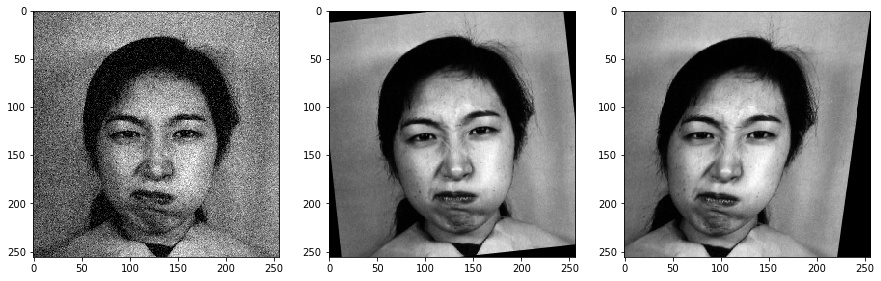

In [3]:
plt.figure(1, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(random_noise(raw_images[0]), cmap = plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(random_rotation(raw_images[0]), cmap = plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(random_skew(raw_images[0]), cmap = plt.cm.gray)

Apply the transformation functions to the dataset to obtain a dataset of 1000 images

In [4]:
augmented_images = raw_images
augmented_raw_labels = raw_labels
size = len(raw_images)
desired_size = 1000
for generated_number in range(desired_size - size):
    #pick a random image from raw images
    r = random.randint(0, size)
    im = raw_images[r]
    #add the label ot augmenetd labels
    augmented_raw_labels.append(raw_labels[r])
    #pick a random trasnformation
    trans = random.randint(1,3)
    if(trans == 1):
        #apply random gaussian noise
        augmented_images.append(random_noise(im))
    elif(trans == 2):
        #apply random rotation
        augmented_images.append(random_rotation(im))
    else:
        #apply random skew
        augmented_images.append(random_skew(im))
print(len(augmented_raw_labels))

1000


In [5]:
num_neutral = augmented_raw_labels.count('NE')
num_happy = augmented_raw_labels.count('HA')
num_sad = augmented_raw_labels.count('SA')
num_surprised = augmented_raw_labels.count('SU')
num_angry = augmented_raw_labels.count('AN')
num_disgust = augmented_raw_labels.count('DI')
num_fear = augmented_raw_labels.count('FE')
print("The number of augmented_labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

The number of augmented_labels are as follows
Neutral : 146  Happy : 154  Sad : 142  Surprised : 131  Angry : 152  Disgust : 136  Fear : 139


### Encoding Labels
Transform the labels into a vector of seven numbers [Neutral Happy Sad Surprised Angry Disgust Fear] where an entry of 1 describes the label of the image

[0 1 0 0 0 0 0] descrbies a happy image

In [6]:
labels_names = ['Neutral', 'Happy', 'Sad', 'Surprised', 'Angry', 'Disgust', 'Fear']
augmented_labels = np.zeros((len(augmented_images), len(labels_names)))
for i, value in enumerate(augmented_raw_labels):
    if(value == 'NE'):
        augmented_labels[i][0] = 1
    elif(value == 'HA'):
        augmented_labels[i][1] = 1
    elif(value == 'SA'):
        augmented_labels[i][2] = 1
    elif(value == 'SU'):
        augmented_labels[i][3] = 1
    elif(value == 'AN'):
        augmented_labels[i][4] = 1
    elif(value == 'DI'): 
        augmented_labels[i][5] = 1
    elif(value == 'FE'):
        augmented_labels[i][6] = 1
    else:
        print('Inavalid Label')
print(len(augmented_labels))
print(augmented_labels[0])

1000
[0. 0. 0. 0. 1. 0. 0.]


### Face detection

Number of faces detected: 1


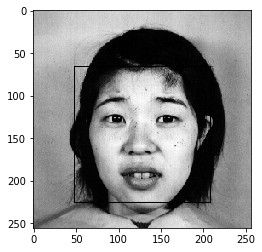

In [7]:
import cv2 
face_cascade = cv2.CascadeClassifier('D:\machine-learning-master\machine-learning-master\projects\Facial Expressions\Project\haarcascade_frontalface_alt.xml')
img = np.array(augmented_images[50])
faces = face_cascade.detectMultiScale(img)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),0)
plt.imshow(img, cmap = plt.cm.gray)


In [8]:
def face_detector(img):
    img = np.array(img)
    return face_cascade.detectMultiScale(img)

remove images that have zero detected faces or more than one detected face. also remove images that have too small detected faces (some images have detected faces that are not actually faces and are too small regions)

In [9]:
num_bad_images = 0
for i,img in enumerate(augmented_images):
    faces = face_detector(img)
    if(len(faces) != 1):
        num_bad_images += 1
        del augmented_images[i]
        augmented_labels = np.delete(augmented_labels, i, axis = 0)
    else:
        if(faces[0][2] < 100 or faces[0][3] < 100):
            num_bad_images += 1
            del augmented_images[i]
            augmented_labels = np.delete(augmented_labels, i, axis = 0)
#check if all bad images are removed
if((desired_size == (len(augmented_images) + num_bad_images)) and (desired_size == (len(augmented_labels) + num_bad_images))):
    print('all bad images removed, {} images remining'.format(len(augmented_images)))
else:
    print('Not all bad images removed please restart kernel')

94
all bad images removed, 999 images remining


#### 